<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_FINAL_TSLA_LSTM_SENTIMENT_60M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

This script shows how the LSTM Model was completed for the TSLA stock. It is the model which includes the Sentiment Data alongside the Transactional Data. The baseline model with just the Transactional Data is found at the Author's Github. 

A similar method was used for the AAPL, MSFT, and AMD stocks. The code for these is found at the Author's Github.

# Import Packages

In [ ]:
pip install yfinance

In [ ]:
pip install statsmodels

In [ ]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=584f1a882f081dc2c281596deb197adcd09d582c37a3f594df065c86e244fb7c
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [ ]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from keras import regularizers
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns 
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Data importing, processing, and analysis

In [ ]:
# Get stock data
start='2020-01-01'
end='2021-01-03'
df = yf.download(tickers = "TSLA",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.head()


[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
0,2020-01-02 09:30:00-05:00,84.900002,85.573997,84.391998,84.780998,84.780998,3205151,85.218002
1,2020-01-02 10:30:00-05:00,84.784004,85.329498,84.524002,85.218002,85.218002,958142,85.264000
2,2020-01-02 11:30:00-05:00,85.229996,85.452003,85.057999,85.264000,85.264000,950558,85.951881
3,2020-01-02 12:30:00-05:00,85.271996,85.970001,85.212578,85.951881,85.951881,1173352,86.078995
4,2020-01-02 13:30:00-05:00,85.955246,86.139145,85.620003,86.078995,86.078995,1246023,85.960098


Text(0, 0.5, 'Cost (USD)')

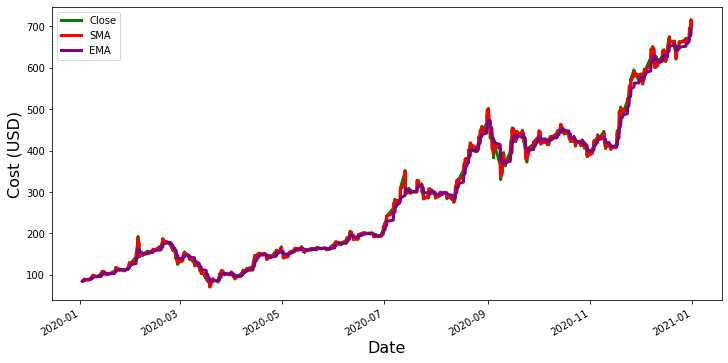

In [ ]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

# Plot price changes for the year
# Colors for the line plot
colors = ['green', 'red', 'purple']
df_plt = df[['Close', 'SMA', 'EMA', 'Datetime']]

# line plot
df_plt.plot(color=colors, x = 'Datetime', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# title and labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cost (USD)', fontsize=16)

In [ ]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')


In [ ]:
# Create hour_id for merging with Sentiment Data
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df[df.columns[-2:]].apply(
    lambda x: '.'.join(x.dropna().astype(str)),
    axis=1
)

In [ ]:
# Import Sentiment Data
sent = pd.read_csv('TSLA_sentiment_hr.csv')
sent

,Unnamed: 0,hour_id,compound,Count,average
0,0,2019-12-31.23,0.8201,1,0.820100
1,1,2020-01-01.0,1.4495,3,0.483167
2,2,2020-01-01.1,0.0000,1,0.000000
3,3,2020-01-01.14,-0.2120,1,-0.212000
4,4,2020-01-01.15,0.0000,1,0.000000
...,...,...,...,...,...
8299,8299,2020-12-31.5,-3.1342,18,-0.174122
8300,8300,2020-12-31.6,2.2985,16,0.143656
8301,8301,2020-12-31.7,-1.1629,16,-0.072681
8302,8302,2020-12-31.8,0.8086,5,0.161720


In [ ]:
# Merge Dataframes
df = pd.merge(df, sent, on = 'hour_id', how = 'left')
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,datehour,Unnamed: 0,compound,Count,average
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1.764000e+03,1763.000000,1764.000000,1764.000000,1.764000e+03,1764.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,288.454734,291.216482,285.507468,288.574462,288.574462,4.048496e+06,288.690057,288.224149,285.474805,2.719539e+08,11.994898,4105.866667,1.338063,35.864848,0.038408
std,167.115233,168.473111,165.640821,167.286553,167.286553,4.410452e+06,167.263532,167.026315,164.889903,1.353014e+08,2.000702,2393.276113,3.491204,49.365795,0.150260
min,70.639999,72.669998,70.102005,70.692680,70.692680,0.000000e+00,70.692680,71.249560,83.142943,0.000000e+00,9.000000,16.000000,-11.681500,1.000000,-0.986600
25%,149.485260,151.497089,147.376999,149.584621,149.584621,1.498679e+06,149.648079,149.650452,149.235594,1.787877e+08,10.000000,2049.250000,-0.428175,8.000000,-0.028982
50%,239.784447,241.849998,237.643997,239.706009,239.706009,2.441167e+06,240.312012,232.277664,219.234638,2.467697e+08,12.000000,4045.500000,0.661950,19.000000,0.036275
75%,421.892464,425.107491,418.199997,421.808266,421.808266,4.818659e+06,421.816544,421.905230,420.886824,3.362978e+08,14.000000,6223.000000,2.369250,42.000000,0.107322
max,715.479980,718.719971,712.659973,715.429993,715.429993,4.321218e+07,715.429993,715.293315,692.313829,6.714171e+08,15.000000,8303.000000,27.861400,519.000000,0.860300


In [ ]:
# Check for correlation between sentiment and price change
df['per_change'] = ((df['Next_close'] - df['Close'])/df['Next_close'])*100
df.corr()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,datehour,Unnamed: 0,compound,Count,average,per_change
Open,1.000000,0.999808,0.999742,0.999661,0.999661,0.421503,0.999104,0.999765,0.997765,0.938356,-0.004375,0.934169,0.188440,0.175332,0.085324,-0.009557
High,0.999808,1.000000,0.999593,0.999819,0.999819,0.431339,0.999278,0.999721,0.997731,0.938169,-0.009576,0.933664,0.188659,0.175041,0.085066,-0.009496
Low,0.999742,0.999593,1.000000,0.999776,0.999776,0.411271,0.999275,0.999631,0.997502,0.938787,0.000970,0.934494,0.188043,0.173525,0.085260,-0.007952
Close,0.999661,0.999819,0.999776,1.000000,1.000000,0.423207,0.999491,0.999706,0.997564,0.938741,-0.004923,0.933939,0.188132,0.173787,0.084920,-0.008317
Adj Close,0.999661,0.999819,0.999776,1.000000,1.000000,0.423207,0.999491,0.999706,0.997564,0.938741,-0.004923,0.933939,0.188132,0.173787,0.084920,-0.008317
Volume,0.421503,0.431339,0.411271,0.423207,0.423207,1.000000,0.422290,0.422200,0.424439,0.326295,-0.375629,0.339723,0.038773,-0.000082,0.031144,-0.036150
Next_close,0.999104,0.999278,0.999275,0.999491,0.999491,0.422290,1.000000,0.999159,0.996981,0.938009,-0.004887,0.933839,0.184358,0.171802,0.083621,0.018566
SMA,0.999765,0.999721,0.999631,0.999706,0.999706,0.422200,0.999159,1.000000,0.998225,0.938323,-0.002596,0.934122,0.188650,0.176009,0.084576,-0.009199
EMA,0.997765,0.997731,0.997502,0.997564,0.997564,0.424439,0.996981,0.998225,1.000000,0.933085,-0.001670,0.936224,0.178526,0.163950,0.082234,-0.010696
obv,0.938356,0.938169,0.938787,0.938741,0.938741,0.326295,0.938009,0.938323,0.933085,1.000000,-0.004528,0.917668,0.169580,0.178655,0.064450,-0.012233


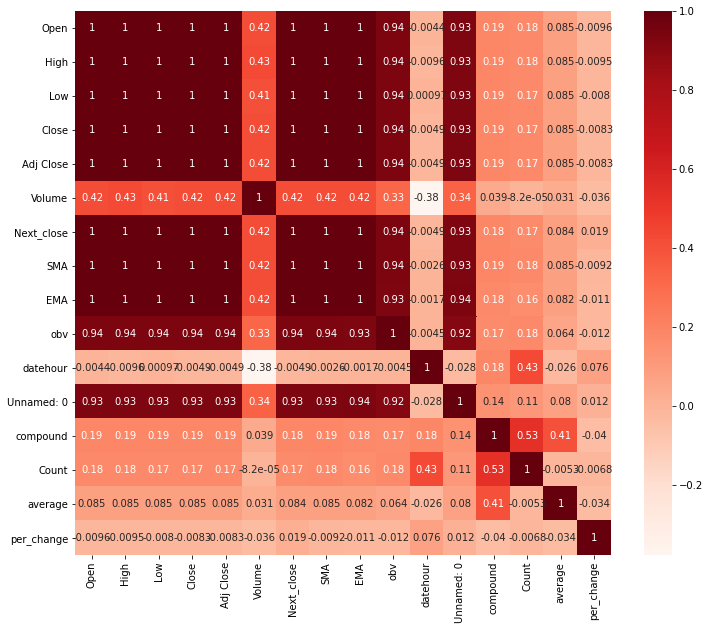

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df = df[['Next_close','Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

In [ ]:
# Scale data with MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()

# Data Loader Parameters
BATCH_SIZE = 17       # Factors of 1411 (train size):  1, 17, 83, 1411
BUFFER_SIZE = 130
TRAIN_SPLIT = round(len(df)*0.8)  # 80-20 train-test split 
print(TRAIN_SPLIT) # Batches should be factor of train size

# LSTM Parameters
EVALUATION_INTERVAL = 20   
EPOCHS = 500 # Early stopping implemented, so this can be artbitrarily high and still work
PATIENCE = 10  # number of epochs to wait before early stop if no progress on the validation set. # Tested this out with other values 3 and 5

1411


In [ ]:
# Scaled data with MinMaxScaler
 # from pandas df to array of values
data = df.values
# define min max scaler
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(data)

In [ ]:
# Split into endogenous and exogenous 
X = dataset[:,1:]
y = dataset[:, 0]


# LSTM Model

In [ ]:
# This was taken from the book Deep Learning with Python by François Chollet 

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 130    # How far back the model looks
future_target = 1 # this analysis is concerned with 1 step (hour/day) into the future
STEP = 1    

x_train_model, y_train_model = multivariate_data(X,y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_model, y_val_model = multivariate_data(X,y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

In [ ]:
print ('Window of past history : {}'.format(x_train_model[0].shape))
print(x_train_model.shape[-2:])

(1281, 130, 9)
Window of past history : (130, 9)
(130, 9)


In [ ]:
train_data_model = tf.data.Dataset.from_tensor_slices((x_train_model, y_train_model))
train_data_model = train_data_model.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() 
val_data_model = tf.data.Dataset.from_tensor_slices((x_val_model, y_val_model))
val_data_model = val_data_model.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  ##Shuffle with buffer

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with input shape of x_train_model.shape[-2:]
model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
model.add(tf.keras.layers.Dense(1)) 

model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #adam said to be best in CV


In [ ]:
# Grid Search
# This build classifier and KerasClassifer step is taken from https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/. It is a wrapped which allows the use of Sklearn CV with Keras

def build_classifier(optimizer, dropout_rate):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                 kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                 input_shape=x_train_model.shape[-2:]))    # LSTM layer with input shape of x_train_model.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #
  return model

grid_model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [1, 17, 83],
              'optimizer' : ['adam','RMSprop'],
              'dropout_rate' : [0.0, 0.1, 0.2],  #What is 'forgotten' - important to avoid overfitting
}

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 2)

In [ ]:
#GridSearchCV
grid_search = grid_search.fit(x_train_model, y_train_model)

640/640 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 14s 19ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 35ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 37ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 35ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 35ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 35ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 36ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 37ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 38ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 37ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 37ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 38ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 38ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 39ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 38ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 37ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 39ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 39ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 37ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1281/1281 [==============================] - 25s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


In [ ]:
print("Best accuracy: {}\nBest combination: {}".format(-grid_search.best_score_, 
                             grid_search.best_params_))

Best accuracy: 0.10002786563734253
Best combination: {'batch_size': 1, 'dropout_rate': 0.0, 'optimizer': 'adam'}


In [ ]:
BATCH_SIZE = 1
DROPOUT_RATE = 0
OPTIMIZER = 'adam'

train_data_model = tf.data.Dataset.from_tensor_slices((x_train_model, y_train_model))
train_data_model = train_data_model.cache().batch(BATCH_SIZE).repeat()
val_data_model = tf.data.Dataset.from_tensor_slices((x_val_model, y_val_model))
val_data_model = val_data_model.cache().batch(BATCH_SIZE).repeat()  

In [ ]:
# Model updated with parameters as determined using Grid Search
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 4, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_model.shape[-2:]
model.add(tf.keras.layers.Dropout(DROPOUT_RATE))   # Add dropout rate
model.add(tf.keras.layers.Dense(1)) 
model.compile(optimizer='RMSprop', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #


In [ ]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

# Train with early stopping so as to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True) 
history = model.fit(train_data_model,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_model,
                                            callbacks=[early_stopping],
                                            validation_steps=17)   

Evaluation Threshold: 20
Epochs: 500
Epoch 1/500
19/20 [===========================>..] - ETA: 0s - loss: nan - mean_absolute_error: nan - mape: nan

ValueError: ignored

In [ ]:
# Plot training 

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
plot_train_history(history,
                   'Single Step Training and validation loss')

In [ ]:
# Plot 3 examples of predictions for different timeframes
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

In [ ]:
for x, y in val_data_model.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 2,
                   'Single Step Prediction')
    plot.show()

## Cross Validation

In [ ]:
# Blocking Cross Validation
n_splits = 10
X = dataset[:,1:]
y= dataset[:,0]

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# Keras Wrapper
from keras.wrappers.scikit_learn import KerasClassifier
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting - is this correct?
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_model.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) 
  return model


In [ ]:
model = KerasClassifier(build_fn=create_model)
btscv = BlockingTimeSeriesSplit(n_splits=10)    # Or should I use TimeSeriesSplit?
mse_block= -cross_val_score(model, x_train_model, y_train_model, cv=btscv, scoring='neg_mean_squared_error')
mae_block = -cross_val_score(model, x_train_model, y_train_model, cv=btscv, scoring='neg_mean_absolute_error')

In [ ]:
print('The mean squared errors for each of the 10 splits are:', mse_block)
print('The mean mse for the folds is: ', (sum(mse_block)/10))

print('The mean absolute errors for each of the 10 splits are:', mae_block)
print('The mean mae for the folds is: ', (sum(mae_block)/10))

In [ ]:
df_results = pd.DataFrame(mse_block)
df_results['RMSE'] = np.sqrt(df_results[0])
df_results = df_results.rename(columns={0:'TSLA_MSE', 'RMSE':'TSLA_RMSE'})
df_results

In [ ]:
df_results.to_csv('TSLA_SENTIMENT_LSTM_HR.csv')


In [ ]:
df_results.describe()